In [1]:
import os
import yaml
import wandb

from jinja2 import Environment, FileSystemLoader

from model_merging.aggregator import aggregate_task_vectors
from model_merging.eval_utils import perform_eval_with_merged_vector
from model_merging.task_vectors import MTLTaskVector
from training.create_network import *
from utils import initialize_wandb

# Login to wandb
wandb.login()

/mnt/lts4/scratch/students/juagarci/simomm/models/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/mnt/lts4/scratch/students/juagarci/simomm/models/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/mnt/lts4/scratch/students/juagarci/simomm/models/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: juan-garciagiraldo (juagarci). Use `wandb login --relogin` to force relogin


True

In [9]:
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template('config/mtl.yaml.j2')
rendered_yaml = template.render()
mm_config = yaml.safe_load(rendered_yaml)

# Create logging folder to store training weights and losses
os.makedirs("logs", exist_ok=True)

model_classes = {
  "split": MTLDeepLabv3,
  "mtan": MTANDeepLabv3
}

In [12]:
initialize_wandb(
  project=mm_config["wandb"]["project"], 
  group=f"{mm_config['training_params']['network']}", 
  job_type="model_merging", 
  mode=mm_config["wandb"]["mode"], 
  config={
    "network": mm_config['model_merging']['network'],
    "dataset": mm_config['model_merging']['dataset'],
    "batch_size": mm_config['training_params']['batch_size'],
    "ft_model_files": mm_config['model_merging']['ft_model_files'],
    "method": mm_config['model_merging']['method'],
    "seed": mm_config['training_params']['seed'],
  }
)

<module 'wandb' from '/opt/conda/lib/python3.10/site-packages/wandb/__init__.py'>

In [4]:
from models.dinov2.mtl.multitasker import MTLDinoV2

pt_model = MTLDinoV2(
  arch_name="vit_base",
  head_tasks={
    "seg": {
      "num_classes": 13,
    },
    "depth": {
      "num_classes": 1,
      "min_depth": 0.001,
      "max_depth": 10.0,
    },
  },
)
# pt_model = torch_load(mm_config["model_merging"]["pt_model_file"])
task_vectors = [MTLTaskVector(pt_model, ft_file) for ft_file in mm_config["model_merging"]["ft_model_files"]]

/mnt/lts4/scratch/students/juagarci/simomm/models/dinov2/losses/cross_entropy_loss.py:220: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [10]:
mtl_task_vector = aggregate_task_vectors(task_vectors, mm_config)

RESOLVING SIGN
Disjoint AGGREGATION: dis-mean
Norm of shared task vector:  tensor(0.3601)


In [6]:
train_tasks_str = ' + '.join(task.title() for task in mtl_task_vector.head_tasks.keys())
print(f"Dataset: {mm_config['model_merging']['dataset'].title()} | Training Task: {train_tasks_str}")

Dataset: Nyuv2 | Training Task: Seg + Depth





=========================================== alpha = 0.00 ===========================================


/mnt/lts4/scratch/students/juagarci/simomm/models/dinov2/losses/cross_entropy_loss.py:220: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Total evaluation time: 22.48s
seg metric: 0.622 | depth metric: 0.4184
Delta MTL: 0.21



=========================================== alpha = 0.25 ===========================================
Total evaluation time: 22.74s
seg metric: 0.6391 | depth metric: 0.4241
Delta MTL: 0.22



=========================================== alpha = 0.50 ===========================================
Total evaluation time: 21.96s
seg metric: 0.6525 | depth metric: 0.4317
Delta MTL: 0.23



=========================================== alpha = 0.75 ===========================================
Total evaluation time: 22.57s
seg metric: 0.6624 | depth metric: 0.4413
Delta MTL: 0.23



=========================================== alpha = 1.00 ===========================================
Total evaluation time: 24.97s
seg metric: 0.6697 | depth metric: 0.4539
Delta MTL: 0.23





Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a58d120d360>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 149, in join
  File "/opt/conda/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
  File "/opt/conda/lib/python3.10/multiprocessing/connection.py", line 931, in wait
  File "/opt/conda/lib/python3.10/selectors.py", line 416, in select
KeyboardInterrupt: 


KeyboardInterrupt: 

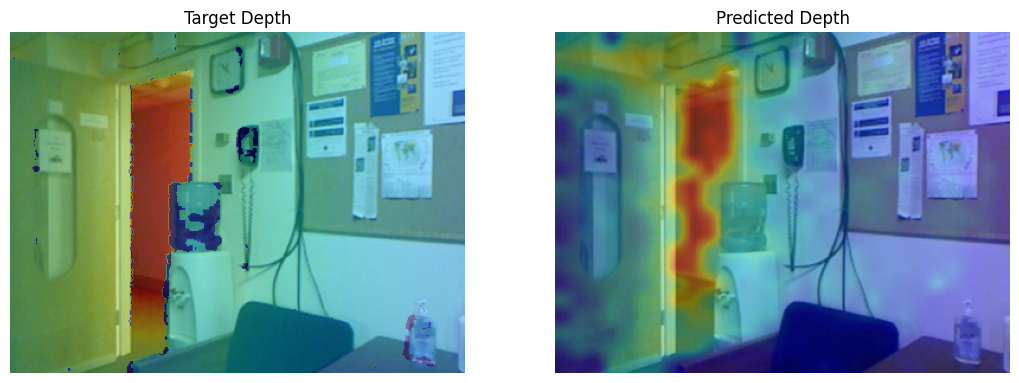

In [13]:
perform_eval_with_merged_vector(pt_model, mtl_task_vector, mm_config)

In [14]:
wandb.finish(quiet=True)

#### Task Arithmetic

Seg + Depth

=========================================== alpha = 0.00 ===========================================
Total evaluation time: 101.41s
seg metric: 0.2166 | depth metric: 0.8741
Delta MTL: -0.39

=========================================== alpha = 0.10 ===========================================
Total evaluation time: 119.07s
seg metric: 0.2545 | depth metric: 0.8934
Delta MTL: -0.37

=========================================== alpha = 0.50 ===========================================
Total evaluation time: 111.14s
seg metric: 0.2004 | depth metric: 1.052
Delta MTL: -0.52

...
Just gets worst for larger alpha



Seg Only

=========================================== alpha = 0.00 ===========================================
Total evaluation time: 80.16s
seg metric: 0.2166
Delta MTL: -0.17

=========================================== alpha = 0.50 ===========================================
Total evaluation time: 75.67s
seg metric: 0.4218
Delta MTL: -0.01

=========================================== alpha = 1.00 ===========================================
Total evaluation time: 80.37s
seg metric: 0.4601
Delta MTL: 0.02


Depth Only

=========================================== alpha = 0.00 ===========================================
Total evaluation time: 79.66s
depth metric: 0.8741
Delta MTL: -0.22

=========================================== alpha = 0.50 ===========================================
Total evaluation time: 80.56s
depth metric: 1.0947
Delta MTL: -0.37

=========================================== alpha = 1.00 ===========================================
Total evaluation time: 94.97s
depth metric: 0.6197
Delta MTL: -0.06

In [8]:
# torch_save(model, 'logging/pt_model.pt')
# torch_load('logging/model_test.pt')